In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.spatial as sc

In [2]:
image_folder_path = "./fruit-inspection-images"
images_second_task_path = os.path.join(image_folder_path, "second-task")
images_second_task = os.listdir(images_second_task_path)

ir_images = []
color_images = []

for img in images_second_task:
    if img[:2] == "C0":
        ir_images.append(img)
    else:
        color_images.append(img)

def load_image(image_number, ir = True):
    ir_image_path = os.path.join(images_second_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_second_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_COLOR)
    return image

def load_image_grey(image_number, ir = True):
    ir_image_path = os.path.join(images_second_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_second_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_GRAYSCALE)
    return image



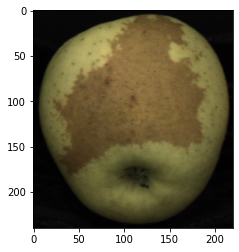

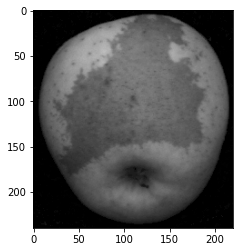

In [4]:
def show_image(image, grey = False):
    if not grey:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap="gray", vmin=0, vmax=255)
    plt.show()

IMAGE_NUMBER = 1

image = load_image(IMAGE_NUMBER, ir=False)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_image(rgb_image)

image_grey = load_image_grey(IMAGE_NUMBER, ir=False)
show_image(image_grey, True)

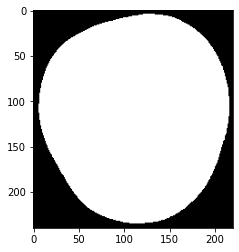

In [5]:
ret, th = cv2.threshold(image_grey, 25, 255, cv2.THRESH_BINARY) #Todo, finn bedre threshold

#Floodfill and invert
th_copy = th.copy()
h, w = th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(th_copy, mask, (0,0), 255)
th_inv = cv2.bitwise_not(th_copy)
im_out = th | th_inv

smooth_mask = cv2.medianBlur(im_out, 3)
#smooth_mask = cv2.GaussianBlur(im_out,(3,3),0)
show_image(smooth_mask, True)

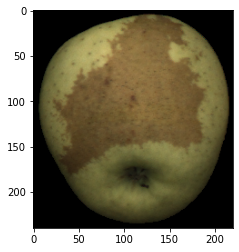

In [6]:
#Get the fruit from the mask
# img_fruit = smooth_mask & image_grey
# show_image(img_fruit, grey=True)

# Generate the mask
img_fruit_color_masked = cv2.bitwise_and(rgb_image, rgb_image, mask=smooth_mask)
show_image(img_fruit_color_masked)

[[2867.74396196 2507.76939099 1372.42594812]
 [2507.76939099 2251.56439336 1233.16574358]
 [1372.42594812 1233.16574358  684.02882098]]
3.6959872051286515
0.01680777891918195


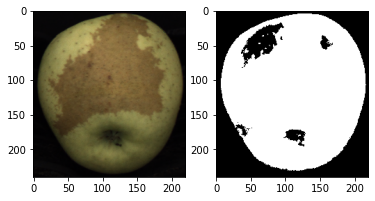

5.113383150094587
0.03206170580998077


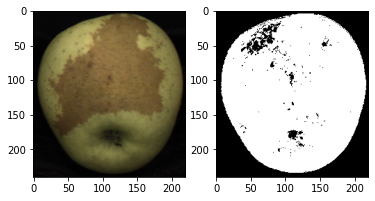

In [25]:
#cv2.Mahalanobis(v1, v2, icova)

#Try out different color spaces here
lab_image = cv2.cvtColor(rgb_image.copy(), cv2.COLOR_RGB2LAB)

lab_channels = cv2.split(lab_image)
L = lab_channels[0]
A = lab_channels[1]
B = lab_channels[2]

rgb_channels = cv2.split(rgb_image)
R = rgb_channels[0]
G = rgb_channels[1]
Bl = rgb_channels[2]

boolean_mask = np.array(smooth_mask, dtype=bool)
mean_L = np.mean(L, where=boolean_mask)
mean_A = np.mean(A, where=boolean_mask)
mean_B = np.mean(B, where=boolean_mask)

mean_R = np.mean(R, where=boolean_mask)
mean_G = np.mean(G, where=boolean_mask)
mean_Bl = np.mean(Bl, where=boolean_mask)

covDataLAB = [L.flatten(), A.flatten(), B.flatten()]
covMatrixLAB = np.cov(covDataLAB, bias=True)

covDataRGB = [R.flatten(), G.flatten(), Bl.flatten()]
covMatrixRGB = np.cov(covDataRGB, bias=True)

print(covMatrixRGB)

def mahalanobis_distance(rgb_image, rgb_mean_vector, covariance_matrix):
    rgb_channels = cv2.split(rgb_image)
    R, G, B = rgb_channels[0], rgb_channels[1], rgb_channels[2]
    R_mean, G_mean, B_mean = rgb_mean_vector[0], rgb_mean_vector[1], rgb_mean_vector[2]
    distance = (((R - R_mean)**2/covariance_matrix[0,0]) + ((G - G_mean)**2/covariance_matrix[1,1]) + ((B - B_mean)**2/covariance_matrix[2,2]))
    return np.sqrt(distance)

distance_rgb = mahalanobis_distance(rgb_image, [mean_R, mean_G, mean_Bl], covMatrixRGB)
distance_lab = mahalanobis_distance(lab_image, [mean_L, mean_A, mean_B], covMatrixLAB)

# print(np.max(distance_rgb))
# print(np.min(distance_rgb))
# print(distance_rgb.shape)

def create_mask(distance_matrix):
    new_image = np.zeros(distance_matrix.shape, dtype=np.uint8)
    print(np.max(distance_matrix))
    print(np.min(distance_matrix))
    for i in range(distance_matrix.shape[0]):
        for j in range(distance_matrix.shape[1]):
            # for th in range(0,10, np.max(distance_matrix)):
            if distance_matrix[i,j] < 1.2:
                new_image[i,j] = 255
            else:
                new_image[i,j] = 0
    plt.subplot(1,2,1)
    plt.imshow(rgb_image)
    plt.subplot(1,2,2)
    plt.imshow(new_image, cmap="gray", vmin=0, vmax=255)
    plt.show()

create_mask(distance_rgb)
create_mask(distance_lab)

# print(rgb_image.shape)
# masked_image = cv2.bitwise_and(rgb_image, rgb_image, mask=mask)

In [2]:
# rgb_reshaped = rgb_image.reshape(rgb_image.shape[0] * rgb_image.shape[1] * 3, 2)
img_fruit_color_AB = lab_image[:, :, 1:3]

img_fruit_color_AB = img_fruit_color_AB.reshape(img_fruit_color_AB.shape[0] * img_fruit_color_AB.shape[1], 2)
print(img_fruit_color_AB.shape)

img_flattened = img_fruit_color_AB.flatten()
img_flattened = img_flattened.reshape(img_flattened.shape[0], 2)
print(img_flattened.shape)


cov, mean = cv2.calcCovarMatrix(rgb_reshaped, None, cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
cov_inv = cv2.invert(cov)

# russet = np.zeros((img_fruit_color_LAB.shape[0], img_fruit_color_LAB.shape[1]), dtype="float64")

mask = np.array(smooth_mask, dtype=bool)

mean1 = np.mean(img_fruit_color_LAB[:,:,1], where = mask)
mean2 = np.mean(img_fruit_color_LAB[:,:,2], where = mask)
print(mean1, mean2)
        
#128 svart

for i in range(img_fruit_color_LAB.shape[0]):
        for j in range(img_fruit_color_LAB.shape[1]):
                if img_fruit_color_LAB[i][j][1] != 128 and img_fruit_color_LAB[i][j][2] != 128 : #is a fruit pixel

                        pixel = np.array(img_fruit_color_LAB[i][j])[1:3].reshape(1, 2)

                        #distance = cv2.Mahalanobis(pixel, mean, cov_inv[1])
                        distance = sc.distance.cdist(pixel, mean, 'mahalanobis', VI=cov_inv[1])
                        
                        #A distance of 1 or lower shows that the point is right among
                        #the benchmark points
                        if distance < 0.8:
                                russet[i][j] = 255
show_image(img_fruit_color_masked)
show_image(russet, True)


NameError: name 'lab_image' is not defined